In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

from pathlib import Path
import cv2
TARGET_HEIGHT = 224
TARGET_WIDTH = 320
from tg3k_eval import combined_segmentation_loss
from utils import load_image_as_array

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



D:\Tool\Anaconda3\envs\dlcv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from pathlib import Path
import cv2

from tg3k_eval import combined_segmentation_loss
from utils import load_image_as_array

TARGET_HEIGHT = 224
TARGET_WIDTH = 320

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_top5_best_and_worst_samples(model, ds):
    all_sample_losses = []

    model.eval()
    with torch.no_grad():
        for idx in range(len(ds)):
            img, mask, meta = ds[idx]

            img_t = img.unsqueeze(0).to(device)
            mask_t = mask.unsqueeze(0).to(device)

            logits = model(img_t)
            loss = combined_segmentation_loss(logits, mask_t, lambda_dice=0.2)

            all_sample_losses.append(loss.item())

    all_sample_losses = np.array(all_sample_losses)
    sorted_indices = np.argsort(all_sample_losses)

    top_5_best_indices = sorted_indices[:5]
    top_5_worst_indices = sorted_indices[-5:][::-1]

    print("Indices of 5 best performing samples (lowest loss):", top_5_best_indices)
    print("Indices of 5 worst performing samples (highest loss):", top_5_worst_indices)

    print("\nLosses for 5 best samples:")
    for i, idx in enumerate(top_5_best_indices):
        print(f"Sample idx={idx}: Loss = {all_sample_losses[idx]:.4f}")

    print("\nLosses for 5 worst samples:")
    for i, idx in enumerate(top_5_worst_indices):
        print(f"Sample idx={idx}: Loss = {all_sample_losses[idx]:.4f}")

    return top_5_best_indices, top_5_worst_indices


def visualize_samples_in_one_plot(ds, model, sample_indices, title_prefix="top 5 best or worst sample visualizations"):
    resize_transform_only = A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH)

    num_samples = len(sample_indices)
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
    fig.suptitle(title_prefix, fontsize=18)

    if num_samples == 1:
        axes = axes.reshape(1, 4)

    model.eval()
    for row, idx in enumerate(sample_indices):
        img_t, mask_t, meta = ds[idx]     
        img_path = Path(meta)

        original_img_np = load_image_as_array(img_path)
        resized_img = resize_transform_only(image=original_img_np)["image"]

        img_batch = img_t.unsqueeze(0).to(device)
        with torch.no_grad():
            probs = torch.sigmoid(model(img_batch))
            pred_mask_np = (probs > 0.5).float().squeeze().cpu().numpy()

        gt_mask_np = mask_t.squeeze().cpu().numpy()

        # overlay
        base_rgb = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
        red_mask = np.zeros_like(base_rgb)
        red_mask[pred_mask_np == 1] = [255, 0, 0]
        overlay = cv2.addWeighted(base_rgb, 1, red_mask, 0.5, 0)

        axes[row, 0].imshow(resized_img, cmap="gray")
        axes[row, 0].set_title(f"Sample idx={idx} Input")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(gt_mask_np, cmap="gray")
        axes[row, 1].set_title("Ground Truth")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(pred_mask_np, cmap="gray")
        axes[row, 2].set_title("Prediction")
        axes[row, 2].axis("off")

        axes[row, 3].imshow(overlay)
        axes[row, 3].set_title("Overlay")
        axes[row, 3].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


def get_saliency_map(img, mask, model):
    img = img.unsqueeze(0).to(device)
    img.requires_grad = True
    mask = mask.to(device)

    output = model(img)
    target = output[0].sum()
    target.backward()

    saliency = img.grad.abs().cpu()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(img.detach().cpu().squeeze(), cmap='gray')
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(saliency.detach().cpu().squeeze(), cmap='hot')
    ax[1].set_title("Saliency")
    ax[1].axis("off")

    ax[2].imshow(mask.detach().cpu().squeeze(), cmap='gray')
    ax[2].set_title("Mask")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


In [3]:
##
# This cell only used for loading pretrain checkpoint
##


import torch
from utils import create_unet_model   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# where to load checkpoint 
ckpt_path = "./tg3k/checkpoints_unet_mim/mim_best.pth"

ckpt = torch.load(ckpt_path, map_location=device)

cfg = ckpt["args"]   
print(cfg)          

model = create_unet_model(
    model_type=cfg["model_type"],        
    in_channels=1,
    out_channels=1,
    base_channels=cfg["base_channels"],
    bilinear=not cfg.get("no_bilinear", False),
    device=device,
)

model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()

model


{'images_dir': '.\\tg3k\\tg3k\\thyroid-image', 'checkpoint_dir': '.\\tg3k\\checkpoints_unet_mim', 'log_dir': '.\\tg3k\\runs\\mim_tg3k_unet', 'split_json': '.\\tg3k\\tg3k\\tg3k-trainval.json', 'model_type': 'unet', 'img_height': 224, 'img_width': 320, 'batch_size': 4, 'epochs': 50, 'num_workers': 0, 'lr': 0.0001, 'weight_decay': 5e-05, 'base_channels': 32, 'no_bilinear': False, 'mask_ratio': 0.55, 'min_block_size': 32, 'max_block_size': 96, 'seed': 42, 'cpu': False, 'resume': None, 'log_interval': 50}
Using standard UNet2D ...


UNet2D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [35]:
##
# This cell only used for loading finetune checkpoint
##


import torch
from tg3k_finetune_segementation import create_unet_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_unet_model(
    model_type="unet",
    in_channels=1,
    out_channels=1,
    base_channels=32,
    bilinear=True,
    device=device,
)

ckpt_path = "./tg3k/checkpoints_finetune/mim_unet/best_model.pth"
state_dict = torch.load(ckpt_path, map_location=device)

model.load_state_dict(state_dict)
model.to(device)
model.eval()

model

In [36]:

import os, json, random
from pathlib import Path

import torch

from tg3k_finetune_segementation import (
    ThyroidDataset,
    get_segmentation_val_transforms_split,
    set_seed,
)

images_dir = r"E:\Data\ToothSeg\tg3k\tg3k\thyroid-image"
masks_dir  = r"E:\Data\ToothSeg\tg3k\tg3k\thyroid-mask"
split_json = r"E:\Data\ToothSeg\tg3k\tg3k\tg3k-trainval.json"

seed = 42
set_seed(seed)

all_image_files = sorted(
    f for f in os.listdir(images_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
)

with open(split_json, "r") as f:
    split_data = json.load(f)

def get_files_from_ids(id_list, available_files):
    file_map = {os.path.splitext(f)[0]: f for f in available_files}
    res = []
    for i in id_list:
        try:
            base = f"{int(i):04d}"
        except Exception:
            base = str(i)
        if base in file_map:
            res.append(file_map[base])
    return res

train_files = get_files_from_ids(split_data["train"], all_image_files)
val_all_files = get_files_from_ids(split_data["val"], all_image_files)

random.seed(seed)
random.shuffle(val_all_files)
split_point = len(val_all_files) // 2
val_files = val_all_files[:split_point]
test_files = val_all_files[split_point:]

print(f"Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

val_common, val_img_tf, val_mask_tf = get_segmentation_val_transforms_split()

val_ds = ThyroidDataset(
    image_ids=val_files,
    images_dir=images_dir,
    masks_dir=masks_dir,
    common_transforms=val_common,
    image_transforms=val_img_tf,
    mask_transforms=val_mask_tf,
)

len(val_ds), val_ds[0][0].shape, val_ds[0][1].shape, val_ds[0][2]


In [37]:
best_indices, worst_indices = get_top5_best_and_worst_samples(model, val_ds)


In [38]:
visualize_samples_in_one_plot(
    ds=val_ds,
    model=model,
    sample_indices=best_indices,
    title_prefix="Top 5 Best Samples (by seg loss using MIM UNet weights)"
)

In [39]:
visualize_samples_in_one_plot(
    ds=val_ds,
    model=model,
    sample_indices=worst_indices,
    title_prefix="Top 5 Worst Samples (by seg loss using MIM UNet weights)"
)

# ## MIM Reconstruction Visualization
#
# Extracted from Dental/MIM_Pretrain.ipynb


# ## TG3K MIM Reconstruction Visualization
#
# Visualizing reconstructed patches for the TG3K dataset.


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from utils import (
    build_ultrasound_transform,
    TG3KMaskedReconstructionDataset,
    get_image_paths,
    create_unet_model,
)

# Paths
DATA_ROOT = Path("./tg3k/tg3k").resolve()
IMAGES_DIR = DATA_ROOT / "thyroid-image"
CHECKPOINT_PATH = Path("./tg3k/checkpoints_unet_mim/mim_best.pth").resolve()

print("IMAGES_DIR     :", IMAGES_DIR)
print("CHECKPOINT_PATH:", CHECKPOINT_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


IMAGES_DIR     : E:\Data\ToothSeg\tg3k\tg3k\thyroid-image
CHECKPOINT_PATH: E:\Data\ToothSeg\tg3k\checkpoints_unet_mim\mim_best.pth
Device: cuda


In [8]:
# Dataset
transform = build_ultrasound_transform(height=224, width=320)
image_paths = get_image_paths(IMAGES_DIR)
print(f"Found {len(image_paths)} images.")

# Use TG3KMaskedReconstructionDataset
mim_dataset = TG3KMaskedReconstructionDataset(
    image_paths=image_paths,
    transform=transform,
    mask_ratio=0.3,
    min_block_size=32,
    max_block_size=96,
)
print("MIM Dataset ready:", len(mim_dataset))

# Model
# Assuming 'unet' model type based on checkpoint path 'checkpoints_unet_mim'
model_mim = create_unet_model(
    model_type="unet",
    in_channels=1,
    out_channels=1,
    base_channels=32,
    bilinear=True,
    device=device,
)

if CHECKPOINT_PATH.exists():
    state = torch.load(CHECKPOINT_PATH, map_location=device)
    if isinstance(state, dict) and "model_state_dict" in state:
        model_mim.load_state_dict(state["model_state_dict"])
    else:
        model_mim.load_state_dict(state)
    print("Loaded MIM weights from:", CHECKPOINT_PATH)
else:
    print(f"Checkpoint not found at {CHECKPOINT_PATH}")

model_mim.eval()


Found 3585 images.
MIM Dataset ready: 3585
Using standard UNet2D ...
Loaded MIM weights from: E:\Data\ToothSeg\tg3k\checkpoints_unet_mim\mim_best.pth


UNet2D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   


=== Reconstruction preview sample 267 ===
Image path : E:\Data\ToothSeg\tg3k\tg3k\thyroid-image\0267.jpg


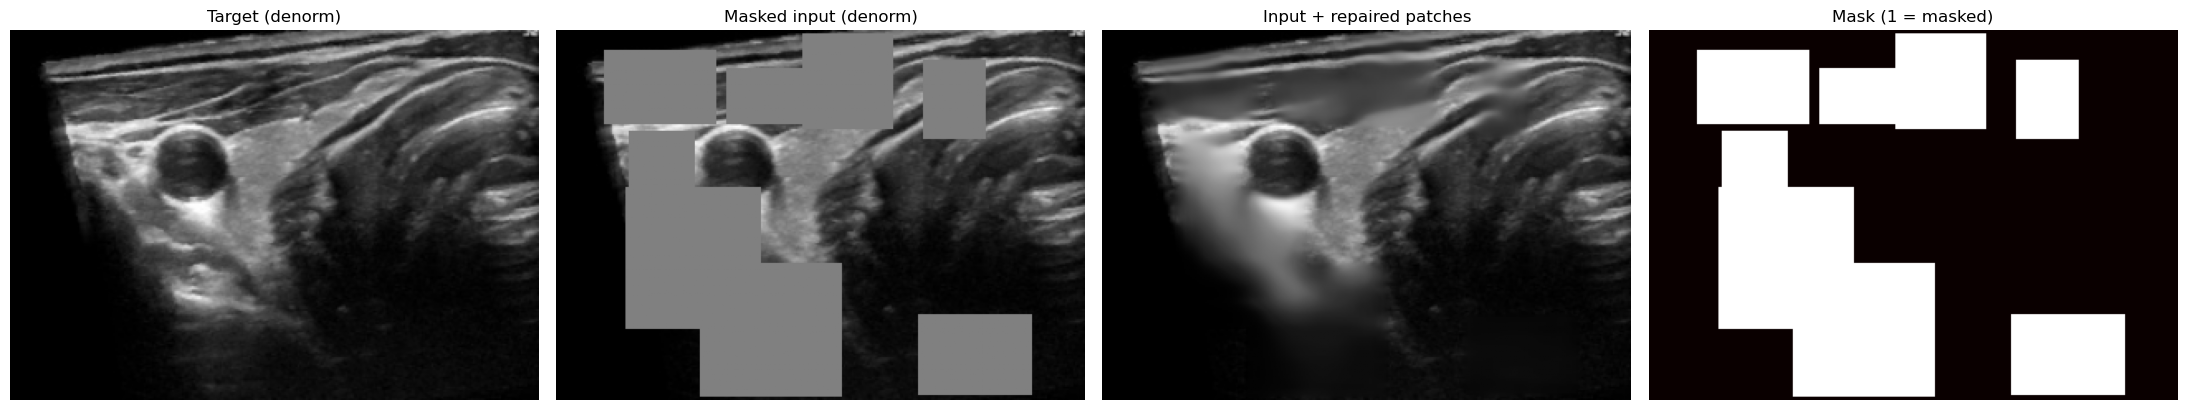


=== Reconstruction preview sample 3103 ===
Image path : E:\Data\ToothSeg\tg3k\tg3k\thyroid-image\3103.jpg


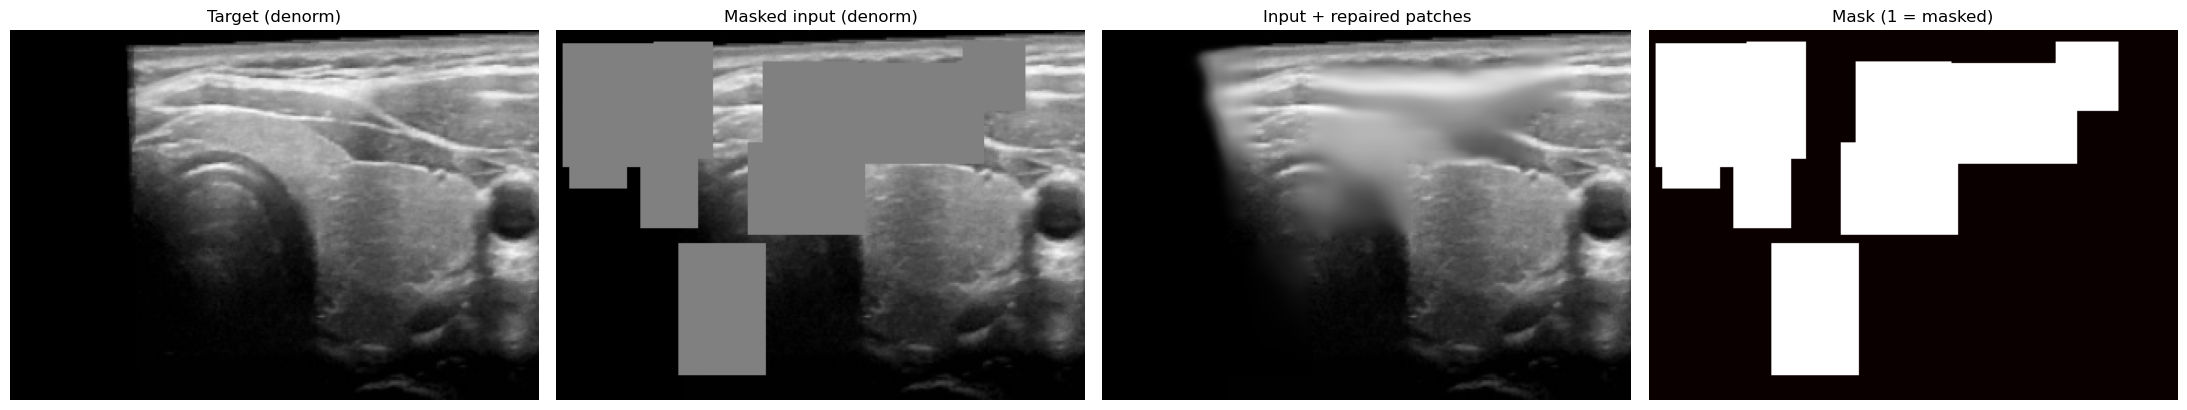


=== Reconstruction preview sample 2394 ===
Image path : E:\Data\ToothSeg\tg3k\tg3k\thyroid-image\2394.jpg


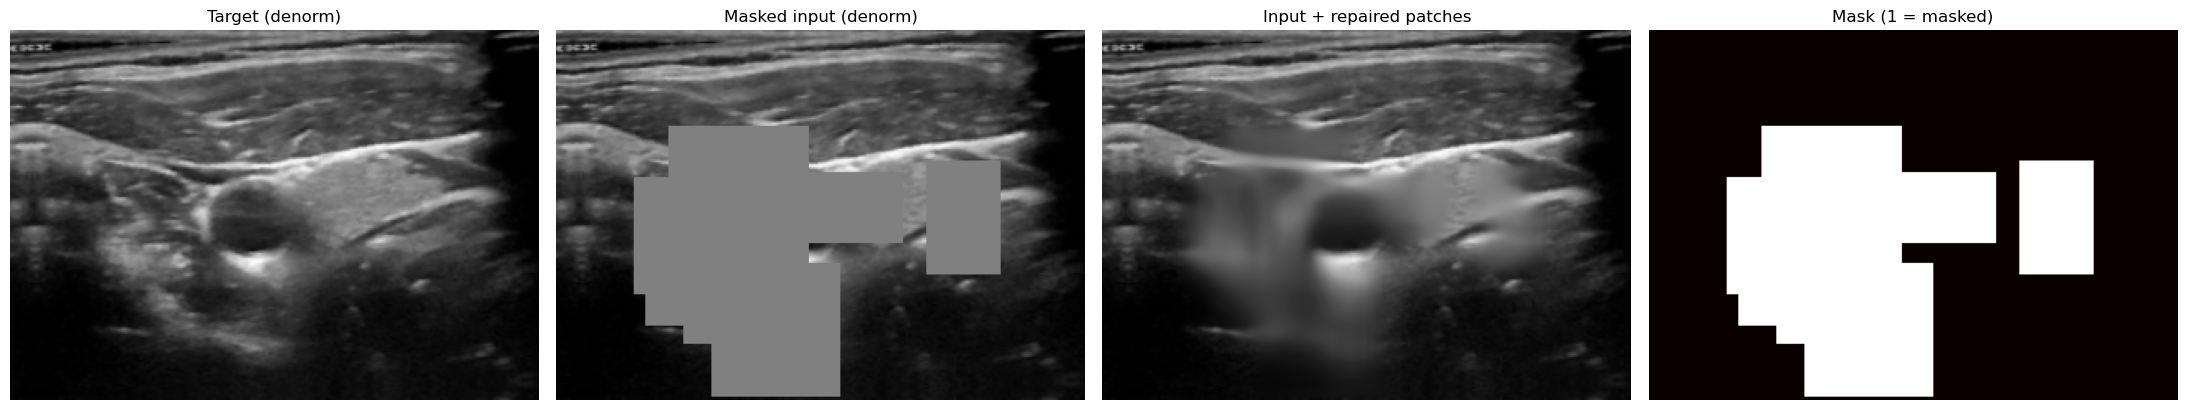

In [9]:
def denorm_np(x_np, mean=0.5, std=0.25):
    x = x_np * std + mean
    x = np.clip(x, 0.0, 1.0)
    return x

NUM_PREVIEW = 3
indices = np.random.choice(len(mim_dataset), NUM_PREVIEW, replace=False)

with torch.no_grad():
    for i in indices:
        masked_img, target_img, mask_tensor, meta = mim_dataset[i]

        masked_img_b = masked_img.unsqueeze(0).to(device)
        pred_b = model_mim(masked_img_b)

        pred_img  = pred_b.squeeze(0).squeeze(0).cpu().numpy()
        target_np = target_img.squeeze(0).cpu().numpy()
        masked_np = masked_img.squeeze(0).cpu().numpy()
        mask_np   = mask_tensor.squeeze(0).cpu().numpy()

        print(f"\n=== Reconstruction preview sample {i} ===")
        print("Image path :", meta["img_path"])

        # Combine
        combined_norm = masked_np + pred_img * mask_np
        combined_vis  = denorm_np(combined_norm)

        target_vis = denorm_np(target_np)
        masked_vis = denorm_np(masked_np)
        
        fig, axes = plt.subplots(1, 4, figsize=(22, 4))

        axes[0].imshow(target_vis, cmap="gray", vmin=0, vmax=1)
        axes[0].set_title("Target (denorm)")
        axes[0].axis("off")

        axes[1].imshow(masked_vis, cmap="gray", vmin=0, vmax=1)
        axes[1].set_title("Masked input (denorm)")
        axes[1].axis("off")

        axes[2].imshow(combined_vis, cmap="gray", vmin=0, vmax=1)
        axes[2].set_title("Input + repaired patches")
        axes[2].axis("off")

        axes[3].imshow(mask_np, cmap="hot", vmin=0, vmax=1)
        axes[3].set_title("Mask (1 = masked)")
        axes[3].axis("off")

        plt.tight_layout()
        plt.show()
